In [ ]:
#import the libraries that are requred
import os
import requests
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

#50 QuickDraw class names taken
class_names = [
    'flower', 'bat', 'lightning', 'umbrella', 'dumbbell', 'flip flops', 'bush', 'nail', 'bridge', 'bread',
    'leg', 'tree', 'cow', 'telephone', 'cup', 'bicycle', 'light bulb', 'crown', 'mouth', 'motorbike',
    'tooth', 'school bus', 'cactus', 'spoon', 'camel', 'helicopter', 'river', 'bird', 'butterfly', 'backpack',
    'table', 'hot air balloon', 'camera', 'hat', 'candle', 'bucket', 'beard', 'banana', 'eye', 'sock',
    'book', 'pillow', 'foot', 'flashlight', 'crab', 'fish', 'pencil', 'leaf', 'apple', 'donut'
]

IMG_SIZE = 128
SAMPLES_PER_CLASS = 6000
BASE_URL = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"
DOWNLOAD_DIR = "/content/quickdraw_npy"
IMG_ROOT = "/content/quickdraw_images"


os.makedirs(DOWNLOAD_DIR, exist_ok=True)
os.makedirs(IMG_ROOT, exist_ok=True)

In [ ]:
#downlaod the data samples
BASE_URL = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"

for class_name in tqdm(class_names, desc="Downloading .npy files"):
    fname = class_name.replace(' ', '%20')
    url = BASE_URL + fname + ".npy"
    output_path = os.path.join(DOWNLOAD_DIR, class_name.replace(" ", "_") + ".npy")

    if not os.path.exists(output_path):
        try:
            r = requests.get(url)
            with open(output_path, 'wb') as f:
                f.write(r.content)
        except:
            print(f"❌ Failed to download: {url}")

In [ ]:
#convert th data to .png 
from tqdm import tqdm
from PIL import Image
import os
import numpy as np

for class_name in tqdm(class_names, desc="Converting to PNG"):
    clean_name = class_name.replace(" ", "_")
    class_dir = os.path.join(IMG_ROOT, clean_name)
    os.makedirs(class_dir, exist_ok=True)

    file_path = os.path.join(DOWNLOAD_DIR, clean_name + ".npy")
    data = np.load(file_path)[:SAMPLES_PER_CLASS]

    for i, img in enumerate(data):
        img = img.reshape(28, 28).astype(np.uint8)
        img = Image.fromarray(img).resize((IMG_SIZE, IMG_SIZE)).convert("RGB")
        img.save(os.path.join(class_dir, f"{i}.png"))


Converting to PNG: 100%|██████████| 50/50 [09:32<00:00, 11.46s/it]


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    IMG_ROOT,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    IMG_ROOT,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 255000 images belonging to 50 classes.
Found 45000 images belonging to 50 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
base_model.trainable = False  # initially freeze it, will later fine tune 

#definng the  hyperparameters 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(class_names), activation='softmax')(x)
learning_rate = 0.001

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 24,125,106 (92.03 MB)

 Trainable params: 537,394 (2.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Unfreeze lsat few layers fine tuning

for layer in base_model.layers[-20:]:
    layer.trainable = True
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 24,125,106 (92.03 MB)

 Trainable params: 9,468,722 (36.12 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

In [ ]:
callbacks = [
    ModelCheckpoint("resnet50_best.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, verbose=1)
]

#start traning themodel
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=9,
    callbacks=callbacks
)

Epoch 1/9
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.5781 - loss: 1.5906


3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1485s 373ms/step - accuracy: 0.5782 - loss: 1.5906 - val_accuracy: 0.6902 - val_loss: 1.1215 - learning_rate: 0.0010
Epoch 2/9
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.6882 - loss: 1.1912


3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1418s 356ms/step - accuracy: 0.6882 - loss: 1.1912 - val_accuracy: 0.7269 - val_loss: 1.0167 - learning_rate: 0.0010
Epoch 3/9
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.7267 - loss: 1.0440


3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1484s 361ms/step - accuracy: 0.7267 - loss: 1.0440 - val_accuracy: 0.7550 - val_loss: 0.8939 - learning_rate: 0.0010
Epoch 4/9
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7486 - loss: 0.9551


3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1423s 357ms/step - accuracy: 0.7486 - loss: 0.9551 - val_accuracy: 0.7587 - val_loss: 0.8847 - learning_rate: 0.0010
Epoch 5/9
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7620 - loss: 0.9049


3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1398s 351ms/step - accuracy: 0.7620 - loss: 0.9049 - val_accuracy: 0.7736 - val_loss: 0.8263 - learning_rate: 0.0010
Epoch 6/9
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.7744 - loss: 0.8602


3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1404s 352ms/step - accuracy: 0.7744 - loss: 0.8602 - val_accuracy: 0.7799 - val_loss: 0.8175 - learning_rate: 0.0010
Epoch 7/9
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.7805 - loss: 0.8310


3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1394s 350ms/step - accuracy: 0.7805 - loss: 0.8310 - val_accuracy: 0.7886 - val_loss: 0.7716 - learning_rate: 0.0010
Epoch 8/9
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7883 - loss: 0.8018


3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1421s 357ms/step - accuracy: 0.7883 - loss: 0.8018 - val_accuracy: 0.7951 - val_loss: 0.7493 - learning_rate: 0.0010
Epoch 9/9
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1413s 354ms/step - accuracy: 0.7944 - loss: 0.7800 - val_accuracy: 0.7949 - val_loss: 0.7495 - learning_rate: 0.0010


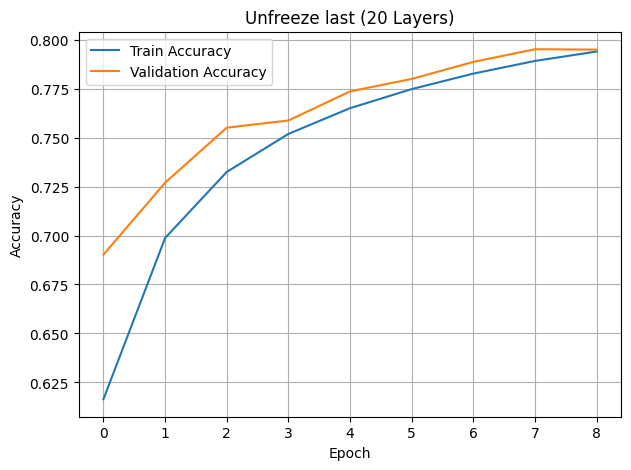

In [ ]:
#plotting the performance in accuracy of training and validation
def plot_history(history, title="Unfreeze last (20 Layers)"):
    plt.figure(figsize=(7,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_history(history, "Unfreeze last (20 Layers)")


In [11]:
print(train_gen.class_indices)

{'apple': 0, 'backpack': 1, 'banana': 2, 'bat': 3, 'beard': 4, 'bicycle': 5, 'bird': 6, 'book': 7, 'bread': 8, 'bridge': 9, 'bucket': 10, 'bush': 11, 'butterfly': 12, 'cactus': 13, 'camel': 14, 'camera': 15, 'candle': 16, 'cow': 17, 'crab': 18, 'crown': 19, 'cup': 20, 'donut': 21, 'dumbbell': 22, 'eye': 23, 'fish': 24, 'flashlight': 25, 'flip_flops': 26, 'flower': 27, 'foot': 28, 'hat': 29, 'helicopter': 30, 'hot_air_balloon': 31, 'leaf': 32, 'leg': 33, 'light_bulb': 34, 'lightning': 35, 'motorbike': 36, 'mouth': 37, 'nail': 38, 'pencil': 39, 'pillow': 40, 'river': 41, 'school_bus': 42, 'sock': 43, 'spoon': 44, 'table': 45, 'telephone': 46, 'tooth': 47, 'tree': 48, 'umbrella': 49}


In [ ]:
#setup for infrence
import os
import numpy as np
from PIL import Image
import random
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from time import perf_counter

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 128
N_IMAGES = 10
MODEL_PATH = "/content/resnet50_best.h5"
NPY_DIR = "/content/quickdraw_npy"
INFER_DIR = "/content/inference_images"

#class mapping that was used in training
class_indices = {
    'apple': 0, 'backpack': 1, 'banana': 2, 'bat': 3, 'beard': 4, 'bicycle': 5, 'bird': 6, 'book': 7, 'bread': 8, 'bridge': 9,
    'bucket': 10, 'bush': 11, 'butterfly': 12, 'cactus': 13, 'camel': 14, 'camera': 15, 'candle': 16, 'cow': 17, 'crab': 18,
    'crown': 19, 'cup': 20, 'donut': 21, 'dumbbell': 22, 'eye': 23, 'fish': 24, 'flashlight': 25, 'flip_flops': 26, 'flower': 27,
    'foot': 28, 'hat': 29, 'helicopter': 30, 'hot_air_balloon': 31, 'leaf': 32, 'leg': 33, 'light_bulb': 34, 'lightning': 35,
    'motorbike': 36, 'mouth': 37, 'nail': 38, 'pencil': 39, 'pillow': 40, 'river': 41, 'school_bus': 42, 'sock': 43, 'spoon': 44,
    'table': 45, 'telephone': 46, 'tooth': 47, 'tree': 48, 'umbrella': 49
}

class_names = [name.replace("_", " ") for name, _ in sorted(class_indices.items(), key=lambda x: x[1])]


In [ ]:

#convert .npy to Images (.png)

selected_classes = random.sample(list(class_indices.keys()), 50)

os.makedirs(INFER_DIR, exist_ok=True)

for class_key in selected_classes:
    npy_path = os.path.join(NPY_DIR, class_key + ".npy")
    data = np.load(npy_path)[:N_IMAGES]
    class_dir = os.path.join(INFER_DIR, class_key)
    os.makedirs(class_dir, exist_ok=True)

    for i, img in enumerate(data):
        img = img.reshape(28, 28).astype(np.uint8)
        img = Image.fromarray(img).resize((IMG_SIZE, IMG_SIZE)).convert("RGB")
        img.save(os.path.join(class_dir, f"{i}.png"))

print(f"\nSaved {N_IMAGES} images each for: {[c.replace('_', ' ') for c in selected_classes]}")



Saved 10 images each for: ['cup', 'backpack', 'pencil', 'hat', 'beard', 'bush', 'dumbbell', 'motorbike', 'river', 'candle', 'light bulb', 'mouth', 'lightning', 'flashlight', 'banana', 'tree', 'flower', 'bridge', 'leg', 'umbrella', 'hot air balloon', 'leaf', 'cow', 'crown', 'table', 'camera', 'crab', 'book', 'camel', 'nail', 'cactus', 'flip flops', 'fish', 'spoon', 'bread', 'butterfly', 'bird', 'bat', 'bucket', 'bicycle', 'helicopter', 'telephone', 'school bus', 'sock', 'pillow', 'donut', 'foot', 'tooth', 'eye', 'apple']


In [ ]:

#Load our Model

model = load_model(MODEL_PATH)
print("Model loaded successfully.")


Model loaded successfully.


In [23]:

#Prepare Data Generator

infer_datagen = ImageDataGenerator(rescale=1./255)

inference_gen = infer_datagen.flow_from_directory(
    INFER_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode=None,
    shuffle=False
)


Found 500 images belonging to 50 classes.


In [ ]:

#Inference time calculation
@tf.function
def infer(x):
    return model(x)

_ = infer(inference_gen[0])

#measure the inference times (excluding first image)
inference_times = []

for i in range(1, len(inference_gen)):
    batch = inference_gen[i]
    start = perf_counter()
    _ = infer(batch)
    end = perf_counter()
    inference_times.append((end - start) * 1000)

avg_time = np.mean(inference_times)
print(f"Inference Time per Image (excluding warm-up): {avg_time:.2f} ms")


Inference Time per Image (excluding warm-up): 7.76 ms


In [ ]:

#Show Predictions made by the model

predicted_labels = []

for i in range(len(inference_gen)):
    batch = inference_gen[i]
    preds = model.predict(batch, verbose=0)
    pred_idx = np.argmax(preds[0])
    pred_label = class_names[pred_idx]
    predicted_labels.append(pred_label)

    img = image.array_to_img(batch[0])
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {pred_label}")
    plt.show()
